# IBM Skillsbuild DataCamp Project:

# Classification of an X-ray image of the human thoracic region into Normal, Bacterial and Viral Pneumonia.

## Importing Libraries  

In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
import glob
import matplotlib.pyplot as plt
import cv2

## Declaring Data Paths

In [2]:
base_path = "./Desktop/chest_xray"

train = base_path + '/train'
test = base_path + '/test'
val = base_path + '/val'

## Visualisation of Datasets

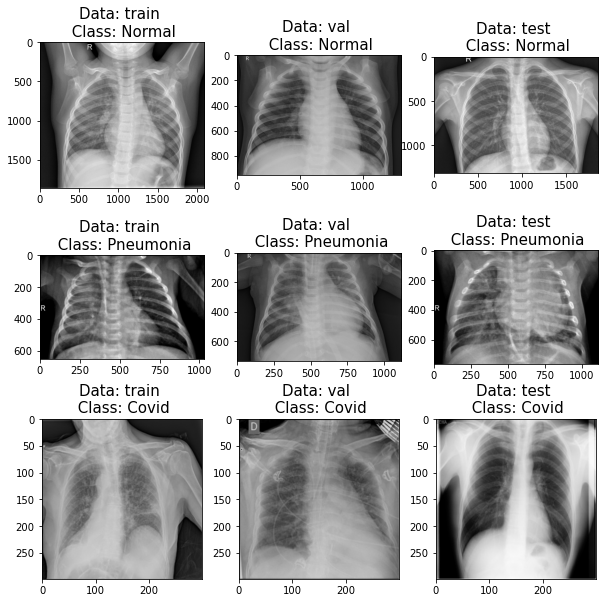

In [3]:
fig, ax = plt.subplots(3, 3, figsize = (10, 10))
ax = ax.ravel()

for i, var in enumerate(['train', 'val', 'test']):
    normal_set = glob.glob(base_path + "/" + var +"/NORMAL/*.jpeg")
    pneumonia_set = glob.glob(base_path + "/" + var + "/PNEUMONIA/*.jpeg")
    covid_set = glob.glob(base_path + "/" + var + "/COVID/*.jpg")
    ax[i].imshow(plt.imread(normal_set[0]), cmap = 'gray')
    ax[i].set_title('Data: {} \n Class: Normal'.format(var), fontsize = 15)
    ax[i+3].imshow(plt.imread(pneumonia_set[0]), cmap = 'gray')
    ax[i+3].set_title('Data: {} \n Class: Pneumonia'.format(var), fontsize = 15)
    ax[i+6].imshow(plt.imread(covid_set[0]), cmap = 'gray')
    ax[i+6].set_title('Data: {} \n Class: Covid'.format(var), fontsize = 15)

## Train Data Visualisation

- The data is firstly being converted into array of 0's and 1's. 
- Here 0 represents Normal condition whereas 1 represents Pneumonia.
- Further it is converted into Pandas Dataframe and visualised using Seaborn.

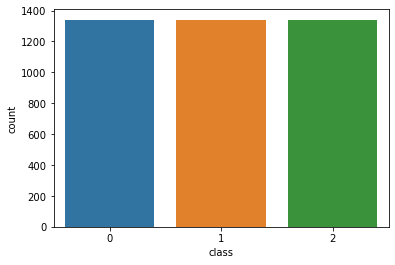

In [4]:
normal_set = glob.glob(train+"/NORMAL/*.jpeg")
pneumonia_set = glob.glob(train+"/PNEUMONIA/*.jpeg")
covid_set = glob.glob(train+"/COVID/*.jpg")

data = pd.DataFrame(np.concatenate([[0]*len(normal_set), [1]*len(pneumonia_set), [2]*len(covid_set)]), columns=["class"])
sns.countplot(data['class'],data=data)


## Representing Training Dataset

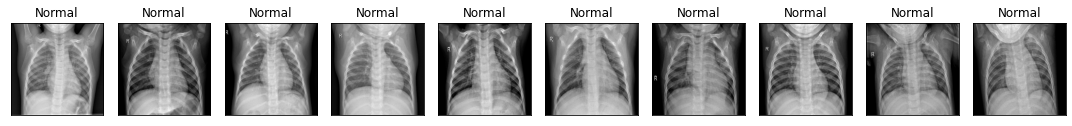

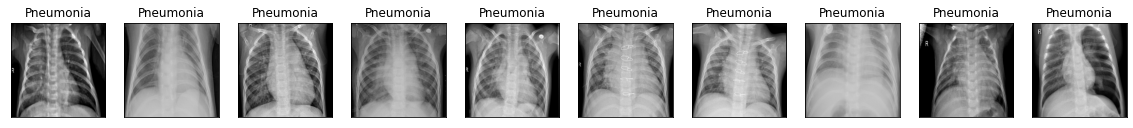

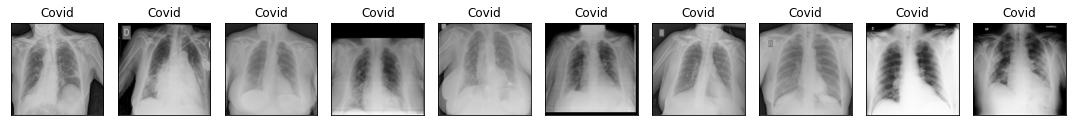

In [5]:
s = (256, 256)

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_set[i])
    img = cv2.resize(img, s)
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20,20), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_set[i])
    img = cv2.resize(img, s)
    ax.imshow(img)
    ax.set_title("Pneumonia")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(covid_set[i])
    img = cv2.resize(img, s)
    ax.imshow(img)
    ax.set_title("Covid")
fig.tight_layout()
plt.show()

## Canny Edge Detection 

- Computer Vision is being used for the processing of images.
- Here, firstly the data is converted into Gray format.
- After that Canny Edge detector is being applied, which reduces cost of computation by removing redudant pixels


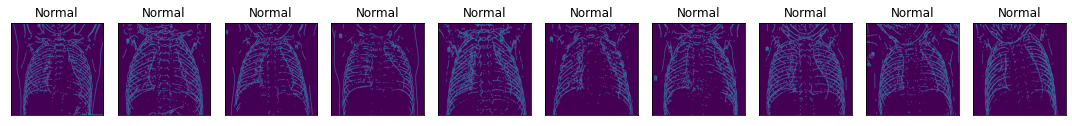

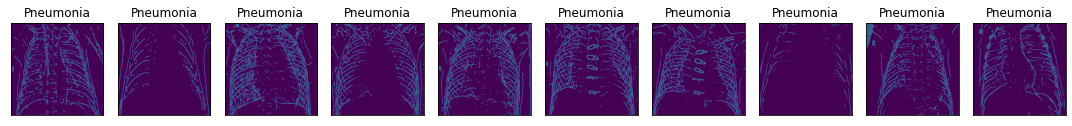

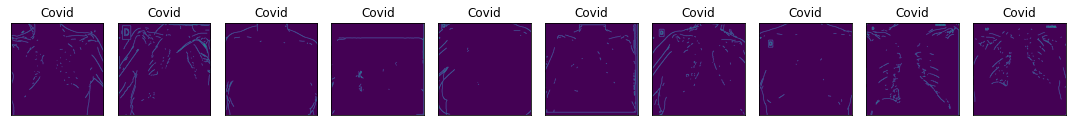

In [6]:
img_size = (512, 512)

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_set[i])
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_set[i])
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Pneumonia")
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(covid_set[i])
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Covid")
fig.tight_layout()
plt.show()

## Creating Image Data Generators

- Images are being rescaled by dividing the pixel values by 255.
- To maintain uniformity in the size of images it is being configured to shape (220, 220).

In [7]:
gen_train = ImageDataGenerator(rescale = 1./255., zoom_range = 0.2)
gen_val = ImageDataGenerator(rescale = 1./255.)
gen_test = ImageDataGenerator(rescale = 1./255.)

train_gen = gen_train.flow_from_directory(train, batch_size = 20, class_mode = 'categorical', target_size = (220, 220))
validation_gen = gen_val.flow_from_directory(val, batch_size = 20, class_mode = 'categorical', target_size=(220, 220))
test_gen = gen_test.flow_from_directory(test, shuffle = False, batch_size=20, class_mode = 'categorical', target_size=(220, 220))

Found 4023 images belonging to 3 classes.
Found 400 images belonging to 3 classes.
Found 383 images belonging to 3 classes.


## Defining The Model

- Here ResNet50 model is being used for creating a basemodel.
- The layers of the base model are made non-trainable.
- This would fix the weights of the layers of the base model.
- The additional layers which are being added on top of the base layer will be trained.


In [8]:
base_model = tf.keras.applications.ResNet50V2(weights = 'imagenet', input_shape = (220, 220, 3), include_top = False)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 24,090,115
Trainable params: 525,315
Non-trainable params: 23,564,800
_________________________________________________________________


## Model Training 

In [9]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

# history = model.fit(train_gen, validation_data = validation_gen, steps_per_epoch = 100, epochs = 11, callbacks = callback)

## Saving/Loading the model

In [10]:
# model.save_weights("model_9450acc_1515loss.h5")

# model.load_weights("model_9450acc_1515loss.h5")

model.load_weights("./Desktop/model3_9450acc.h5")

## Plotting Accuracy and Loss Curves

In [11]:
# accuracy = history.history['accuracy']
# val_accuracy  = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

In [12]:
# plt.figure(figsize=(15,10))

# plt.subplot(2, 2, 1)
# plt.plot(accuracy, label = "Training accuracy")
# plt.plot(val_accuracy, label="Validation accuracy")
# plt.ylim(0.8, 1)
# plt.legend()
# plt.title("Training accuracy vs validation accuracy")


# plt.subplot(2,2,2)
# plt.plot(loss, label = "Training loss")
# plt.plot(val_loss, label="Validation loss")
# plt.ylim(0, 0.5)
# plt.legend()
# plt.title("Training loss vs validation loss")

# plt.show()

## Prediction Evaluation

In [13]:
y_pred = model.predict(test_gen)

y_pred

array([[9.99999642e-01, 2.09532729e-07, 1.51857463e-07],
       [1.00000000e+00, 1.47590375e-08, 1.80555004e-09],
       [9.99969959e-01, 5.48280283e-08, 3.00028987e-05],
       ...,
       [1.46818529e-05, 1.18467571e-04, 9.99866843e-01],
       [5.28828150e-06, 2.49284934e-02, 9.75066245e-01],
       [3.46560256e-08, 9.95878458e-01, 4.12149774e-03]], dtype=float32)

In [14]:
y_pred_list = []

for i in range(len(y_pred)):
    y_pred[i] = np.where(y_pred[i] == np.amax(y_pred[i]))
    y_pred_list.append(y_pred[i][0])

y_pred_list

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0

In [15]:
norm = glob.glob(base_path + "/test/NORMAL/*.jpeg")
pneu = glob.glob(base_path + "/test/PNEUMONIA/*.jpeg")
cov = glob.glob(base_path + "/test/COVID/*.jpg")

In [16]:
#bad, but yeah:out = []

for i in range(len(cov)):
    out.append(2.0)
for i in range(len(pneu)):
    out.append(1.0)
for i in range(len(norm)):
    out.append(0.0)

v=np.array(out)

## Confusion Matrix

In [17]:
matrix = confusion_matrix(out, y_pred_list, labels=[0,1,2])
print(matrix)

[[  0   9 108]
 [  1 113   2]
 [149   0   1]]


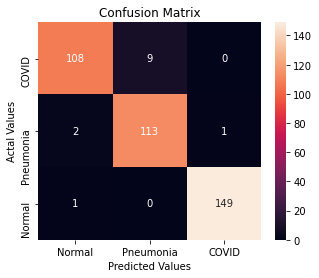

In [18]:
cm_df = pd.DataFrame(matrix, index = ['COVID','Pneumonia','Normal'], columns = ['COVID','Pneumonia','Normal'])
plt.figure(figsize=(5,4))
ax = sns.heatmap(cm_df, annot=True, fmt="d")
ax.invert_xaxis()
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()